# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

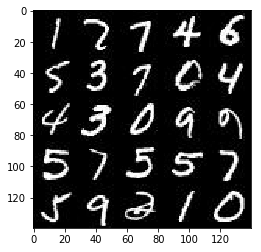

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

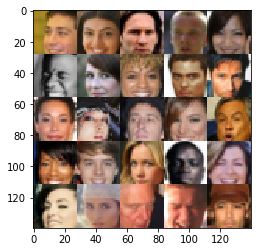

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input')
    fake_input = tf.placeholder(tf.float32, (None, z_dim), name = 'z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, fake_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14 x 14 x 16
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7 x 7 x 32 
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn3, bn3)
        
        # 7 x 7 x 64
        
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = .2
    with tf.variable_scope('generator', reuse=not is_train):
        # 28 x 28 x 3
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 7 x 7 x 32
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # 14 x 14 x 16
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28 x 28 x 8
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        # 28 x 28 x 3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #https://discussions.udacity.com/t/project-5-net-not-training/246936/9?u=keenencatesphevy
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train, g_train
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    
    figsize=(5,5)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, img_d, data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 5.4870
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 4.6599
Epoch 1/2... Discriminator Loss: 0.0333... Generator Loss: 5.8478
Epoch 1/2... Discriminator Loss: 0.0091... Generator Loss: 7.3393
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 4.0726
Epoch 1/2... Discriminator Loss: 0.2517... Generator Loss: 2.2082
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.5873
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 2.5534... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 1.1782


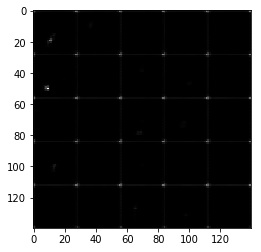

Epoch 1/2... Discriminator Loss: 2.3413... Generator Loss: 0.4319
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 1.7665... Generator Loss: 1.4968
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.5969
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 1.2264
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.9393
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 1.8947


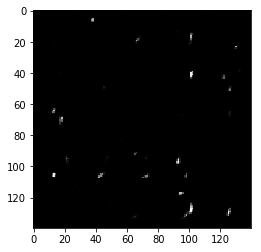

Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.4920
Epoch 1/2... Discriminator Loss: 1.6694... Generator Loss: 0.3467
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.7524... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 2.1511... Generator Loss: 0.2263
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 0.3066
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.8916
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.6146


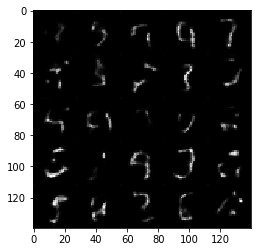

Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.4516
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 1.5579
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.5229


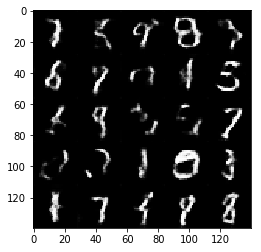

Epoch 1/2... Discriminator Loss: 1.9933... Generator Loss: 0.2159
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.3878
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 0.8949


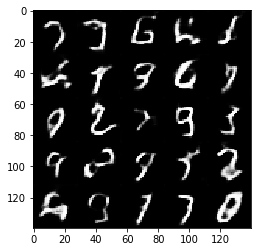

Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.3445
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.6358


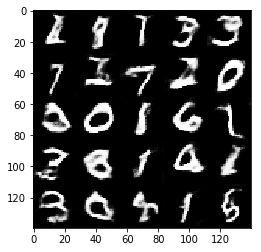

Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.4398
Epoch 1/2... Discriminator Loss: 1.5065... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 2.2160
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.6930


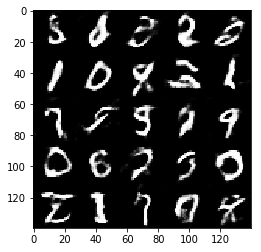

Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 1.4714
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.5692


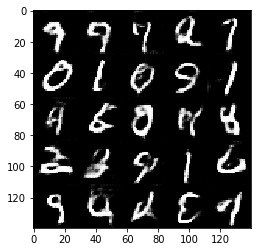

Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.3530
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 1.6350
Epoch 1/2... Discriminator Loss: 1.6894... Generator Loss: 0.3518
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 1.8833... Generator Loss: 0.2500
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 1.4330


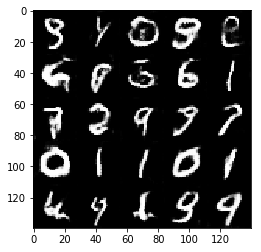

Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 1.6649
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.3868
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 1.1915... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.5386... Generator Loss: 1.7323


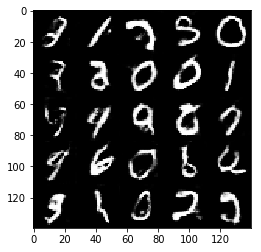

Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.3213
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.5178
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.5277... Generator Loss: 0.4042


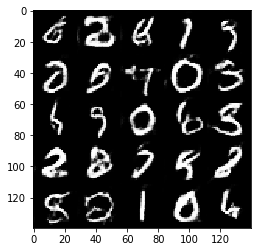

Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 1.7762
Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.3740
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.5317
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.3722


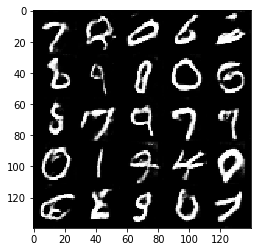

Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 1.2533
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 1.3723
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.4071
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.4102
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.7856


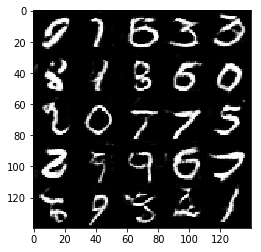

Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.4601
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.2415
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.9727
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.7203... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 1.1217
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.7871


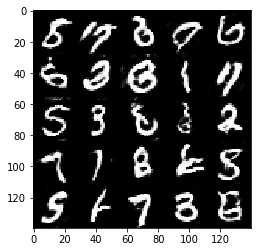

Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 1.4944
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 0.3479
Epoch 2/2... Discriminator Loss: 1.7569... Generator Loss: 2.9011
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 1.7212
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 1.9435... Generator Loss: 2.4718
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.4048


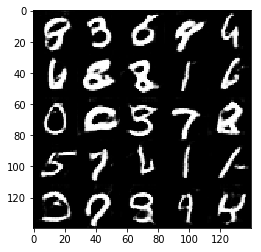

Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.3514
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.4720
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 1.3756
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.5789


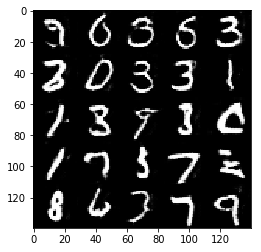

Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 1.8977
Epoch 2/2... Discriminator Loss: 2.0223... Generator Loss: 1.4868
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.1626
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.1420
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 1.3326
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 2.0707... Generator Loss: 2.3033


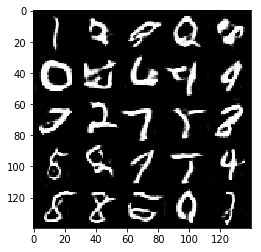

Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 1.6035... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.5488
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 0.8606


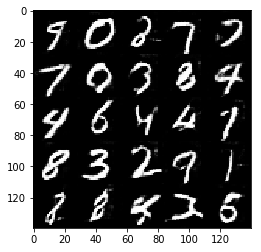

Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.5038
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 2.0804
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7552


In [23]:
batch_size = 64
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 28.8035
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 5.7910
Epoch 1/1... Discriminator Loss: 6.7803... Generator Loss: 0.1601
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 2.7465... Generator Loss: 4.5935
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 3.0835
Epoch 1/1... Discriminator Loss: 2.4099... Generator Loss: 4.6470
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 2.9458
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 3.8654
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 2.7547


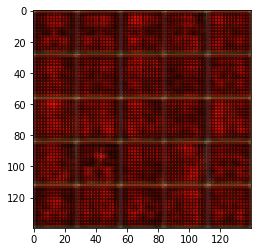

Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.9821
Epoch 1/1... Discriminator Loss: 2.5425... Generator Loss: 6.1897
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.9926... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 4.1052... Generator Loss: 0.0257
Epoch 1/1... Discriminator Loss: 1.8350... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 2.0116... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 2.7677... Generator Loss: 0.0987


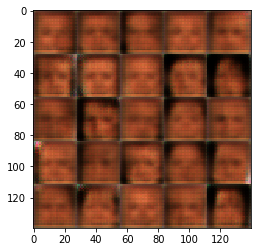

Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.8750... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8549


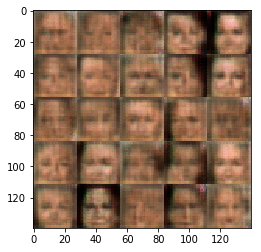

Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7607


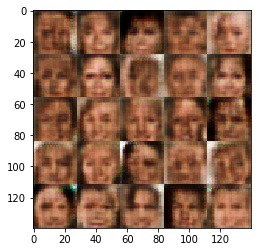

Epoch 1/1... Discriminator Loss: 1.8610... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.7892... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 1.0497


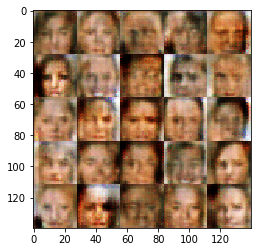

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.8831


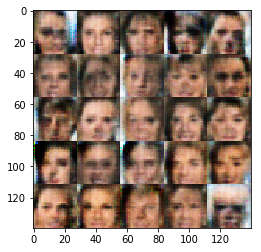

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.3251
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8421


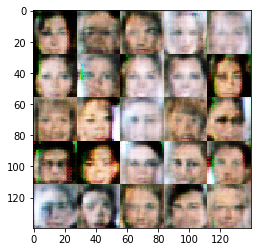

Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5262


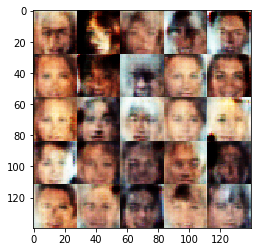

Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6059


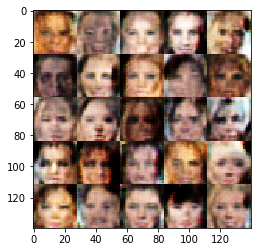

Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.9402


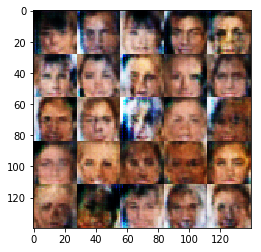

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7110


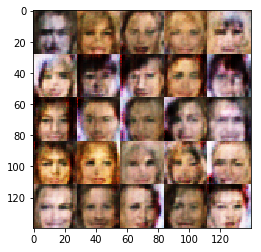

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5982


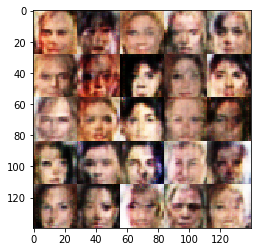

Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6610


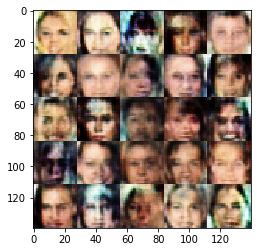

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 2.3513... Generator Loss: 0.2164
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 2.3438... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7947


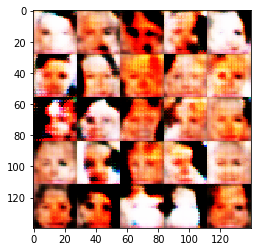

Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 2.9475... Generator Loss: 0.0772
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 2.0978... Generator Loss: 2.1809
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.0620


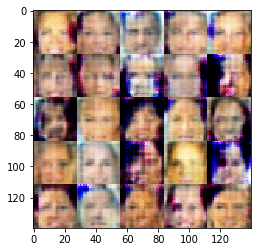

Epoch 1/1... Discriminator Loss: 1.8955... Generator Loss: 0.2053


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = .001
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.